<a href="https://colab.research.google.com/github/valid999/Generative_Adversarial_Network/blob/main/Generative_Adversarial_Networks_20_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## We simultaneously train two models the G Generator capture the data distribution  & the D Discriminator  estimates the probability that a sample came from the training data rather than G , The training procedure for G is to maximize the probability of D making a mistake  , The entire system can train with backpropagation without the markov process , what is the markove process : stochastic model describing a sequence of possible events in which the probability of each event depends only on the state attained in the previous event .

In [219]:
# Import libraries

import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.animation as animation
from IPython.display import HTML
import matplotlib.pyplot as plt


# Set random seed for the reproducibility
manualSeed = 999

# ManualSeed  = random.randint(1 , 10000)  # use if you want new results
print('Random Seed: ' , manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True)  # Needed for the reproducible results

Random Seed:  999


In [220]:
# Root direc tory for the dataset
dataroot =  '/content/drive/MyDrive/Colab Notebooks/'

# Number of workers of the dataloader
workers = 2

# Batch size during training
batch_size = 200

# Spatial size of training imagess . All images will be resized to be resized to this
# size using a tranformer
image_size = 64

# Number of channels in the training dimages for color images this is 3
nc = 3

# Size of z latent vector (size of generator input)
nz = 50

# Size of feature maps in generator
ngf = 32

# Number of feature maps in discriminator
ndf = 32

# Number of training epochs
num_epochs = 1000

# Learning rate for the optimizers
lr = 0.001

# Beta1 hyperparameter for the Adam optimizers
beta1 = 0.3

# Number of GPUs available . USe 0 for CPU mode.
ngpu = 1




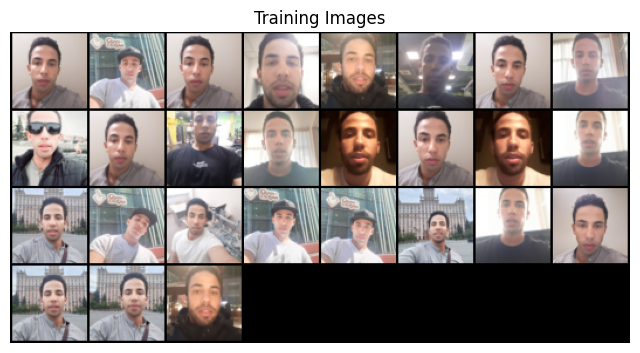

In [221]:
# Let's preprocess the dataset

dataset = dset.ImageFolder(root = dataroot,
                          transform = transforms.Compose([
                              transforms.Resize(image_size),
                              transforms.CenterCrop(image_size),
                              transforms.ToTensor(),
                              transforms.Normalize((0.5 , 0.5 , 0.5) , (0.5 , 0.5 , 0.5))
                          ])
                          )

# Create the datloader
dataloader = torch.utils.data.DataLoader(dataset , batch_size = batch_size ,
                                         shuffle = True , num_workers = workers)


# Decide which device we want to run on
device = torch.device("cuda:0"if (torch.cuda.is_available() and ngpu > 0 ) else 'cpu')


# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize = (8 , 8))
plt.axis('off')
plt.title('Training Images')
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64] , padding = 2 , normalize = True).cpu() , (1 , 2 , 0)))

#### Let's initilization of  the weight


In [222]:
# Custom the weight initilaization called on 'netG' & 'netD

def weights_init(m):
  classname = m.__class__.__name__
  if classname.find('Conv') != -1:
    nn.init.normal_(m.weight.data , 0.0 , 0.02) # stdv = 0.00 , weights_init = = 0.02
  elif classname.find('batchNorm') != -1:
    nn.init.normal_(m.weight.data , 1.0 , 0.02)
    nn.init.constant_(m.bias.data , 0)



### Generator

In [223]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. ``(ngf*8) x 4 x 4``
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. ``(ngf*4) x 8 x 8``
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. ``(ngf*2) x 16 x 16``
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. ``(ngf) x 32 x 32``
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. ``(nc) x 64 x 64``
        )

    def forward(self, input):
        return self.main(input)

In [224]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
#  to ``mean=0``, ``stdev=0.02``.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(50, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


#### Discriminator

In [225]:
class Discriminator(nn.Module):

  def __init__(self , ngpu):
    super(Discriminator , self).__init__()
    self.ngpu = ngpu
    self.main = nn.Sequential(
        # Input is (nc) * 64 * 64 * 64
        nn.Conv2d(nc , ndf , 4 , 2, 1 , bias = False),
        nn.LeakyReLU(0.2 ,  inplace = True),
        # State size (ndf) * 32 * 32
        nn.Conv2d(ndf , ndf * 2 , 4 , 2, 1 , bias = False),
        nn.BatchNorm2d(ndf * 2),
        nn.LeakyReLU(0.2 , inplace = True),
        # sate size , (ndf * 2) * 16 * 16
        nn.Conv2d(ndf * 2 , ndf *4 , 4 , 2 , 1 ,  bias = False),
        nn.BatchNorm2d(ndf * 4),
        nn.LeakyReLU(0.2 , inplace = True),
        # State size (ndf*4) * 8 * 8
        nn.Conv2d(ndf * 4 , ndf * 8 , 4 , 2 , 1 , bias = False),
        nn.BatchNorm2d(ndf * 8),
        nn.LeakyReLU(0.2 , inplace = True),
        # State size (ndf*8) * 4 * 4
        nn.Conv2d(ndf * 8 , 1 , 4 , 1 , 0 , bias = False),
        nn.Sigmoid()

    )

  def  forward(self , input):
    return self.main(input)

In [226]:
# Create the discriminator
netD = Discriminator(ngpu).to(device)


# Handle multi GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
  netD = nn.DataParallel(netD , list(range(ngpu)))



netD.apply(weights_init)

# print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [227]:
# Initilize the BCELoss function
criterion = nn.BCELoss()

# Create the batch of latent vectors that we will use to visualize
# the progression of the generator
fixed_noise = torch.randn(64 , nz , 1 , 1 , device = device)

# Establish convection for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD  = optim.Adam(netD.parameters() , lr = lr , betas = (beta1 , 0.999))
optimizerG =  optim.Adam(netG.parameters() , lr , betas = (beta1 , 0.999))

In [228]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/1000][0/1]	Loss_D: 1.7225	Loss_G: 11.3788	D(x): 0.5822	D(G(z)): 0.6463 / 0.0000
[1/1000][0/1]	Loss_D: 0.6427	Loss_G: 11.5344	D(x): 0.8931	D(G(z)): 0.3429 / 0.0000
[2/1000][0/1]	Loss_D: 0.2613	Loss_G: 10.6402	D(x): 0.9202	D(G(z)): 0.1436 / 0.0000
[3/1000][0/1]	Loss_D: 0.6212	Loss_G: 16.2767	D(x): 0.9706	D(G(z)): 0.3805 / 0.0000
[4/1000][0/1]	Loss_D: 0.9399	Loss_G: 6.5860	D(x): 0.4928	D(G(z)): 0.0003 / 0.0030
[5/1000][0/1]	Loss_D: 5.6677	Loss_G: 18.1513	D(x): 0.9994	D(G(z)): 0.9936 / 0.0000
[6/1000][0/1]	Loss_D: 0.4068	Loss_G: 14.6502	D(x): 0.7939	D(G(z)): 0.0000 / 0.0000
[7/1000][0/1]	Loss_D: 0.0343	Loss_G: 7.3937	D(x): 0.9730	D(G(z)): 0.0045 / 0.0033
[8/1000][0/1]	Loss_D: 3.5265	Loss_G: 18.8506	D(x): 0.9902	D(G(z)): 0.9225 / 0.0000
[9/1000][0/1]	Loss_D: 0.9898	Loss_G: 15.4885	D(x): 0.4518	D(G(z)): 0.0000 / 0.0000
[10/1000][0/1]	Loss_D: 0.0360	Loss_G: 9.9884	D(x): 0.9673	D(G(z)): 0.0009 / 0.0010
[11/1000][0/1]	Loss_D: 0.5831	Loss_G: 11.5407	D(x): 0.9882	D(G(

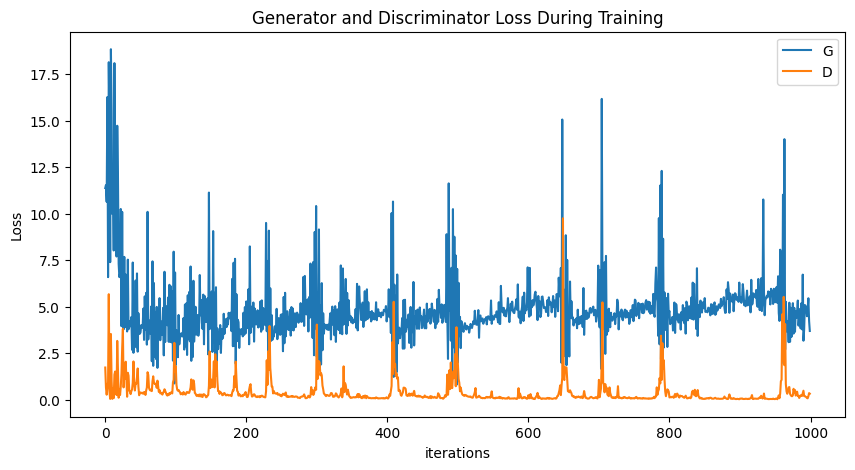

In [229]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

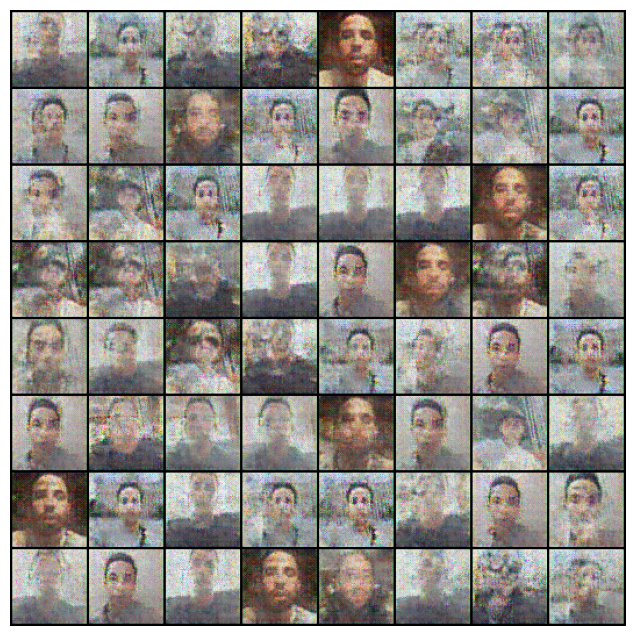

In [242]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval= 1500, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())


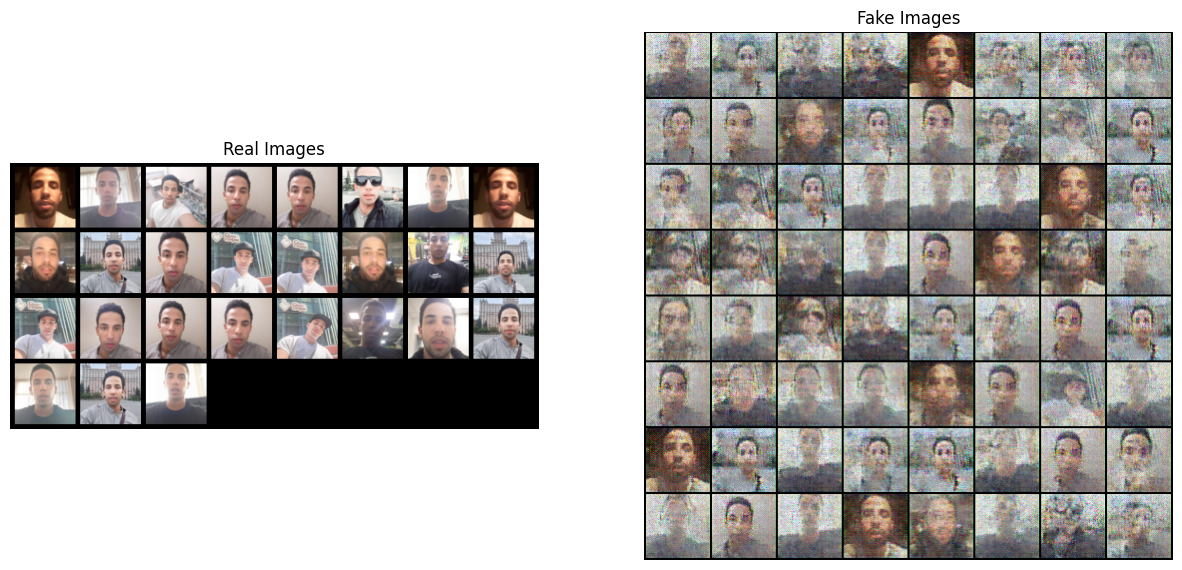

In [231]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()